In [1]:
# this script is for analyse PDB distances in MSAs, grouping them by size of the CRE as follows:
# Group1: KD - short peptide (CRE in other chain); Group2: KD - CRE being part of another domain; Group3: KD - more domains

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
from itertools import combinations

## first approach - grouping by CRE size in MSAs with structure

In [2]:
# Load datasets
to_calculate = pd.read_csv('../datasets/to_calculate_distances.tsv', sep= '\t')
msa_regions_pdbs = pd.read_csv('../datasets/msa_regions_pdbs.tsv', sep= '\t')
distances_median = pd.read_csv('../datasets/distances_median.tsv', sep= '\t')

In [3]:
msa_regions_pdbs.columns

Index(['msa', 'uniprot', 'start_cre', 'end_cre', 'term_id_cre', 'length_cre',
       'pdb', 'start_pdb', 'end_pdb', 'overlap_cre', 'start_kd', 'end_kd',
       'term_id_kd', 'length_kd', 'overlap_kd', 'no_seqs', 'no_pdbs'],
      dtype='object')

In [4]:
cre_length = msa_regions_pdbs[['term_id_cre', 'length_cre']].drop_duplicates()

In [5]:
cre_length.sort_values("length_cre")

,term_id_cre,length_cre
912,cre224,9
669,cre95,10
919,cre233,10
827,cre197,10
823,cre133,10
822,cre132,10
821,cre131,10
922,cre273,10
345,cre40,12
61,cre38,14


/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


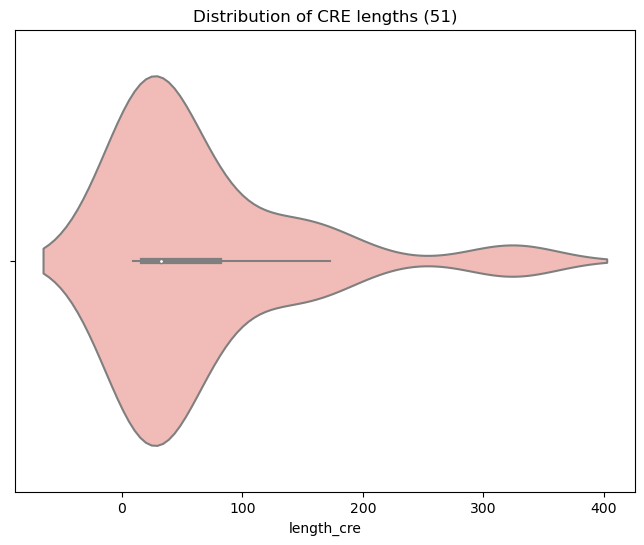

In [6]:
plt.figure(figsize= (8,6))
sns.violinplot(cre_length.length_cre, palette= 'Pastel1')
plt.title(f"Distribution of CRE lengths ({msa_regions_pdbs.term_id_cre.nunique()})")
plt.show()

In [7]:
cre_length.length_cre.describe()

count     51.000000
mean      67.647059
std       81.490324
min        9.000000
25%       17.500000
50%       33.000000
75%       81.000000
max      328.000000
Name: length_cre, dtype: float64

In [8]:
# Add distances to MSAs dataframe
msa_median = msa_regions_pdbs.merge(distances_median, how= 'left')
# Keep MSAs with 2 or more pdbs
msa_median = msa_median[msa_median.no_pdbs > 1]

In [9]:
# drop NaNs values
df = msa_median[['msa', 'pdb', 'median', 'distances']].dropna() # 635 unique PDBs with distance information

No handles with labels found to put in legend.


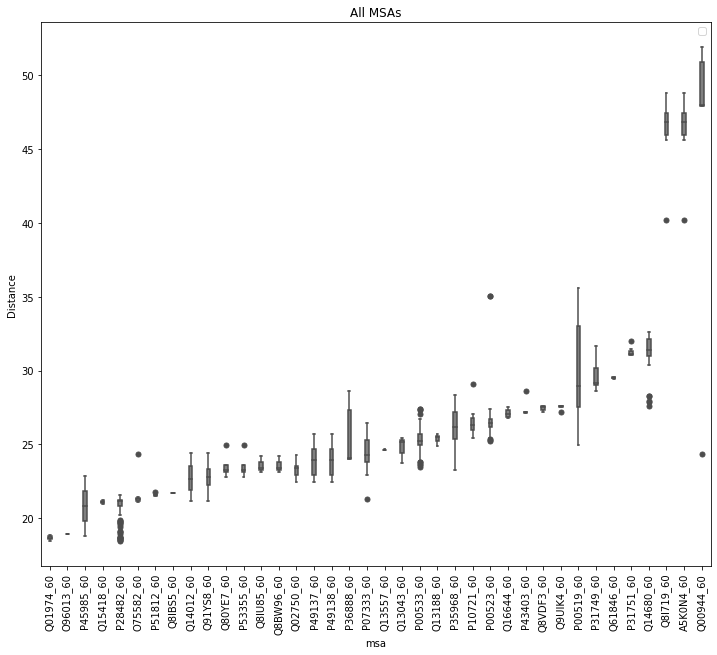

In [7]:
# Calculate median for each MSA
medians = df.groupby('msa')['median'].median().sort_values()

# Create a new figure
plt.figure(figsize=(12,10))

# Create a boxplot for all MSAs, sorted by median value
flierprops = dict(marker = 'o')
sns.boxplot(data= df, y='median', x= 'msa', order=medians.index, width= 0.2, color= 'gray', flierprops= flierprops)

# Add title and axis labels
plt.legend()
plt.title("All MSAs")
plt.ylabel('Distance')
plt.xticks(rotation= 90)

# Show the plot
plt.show()

In [58]:
# Group 1: CRE < 50 residues
g1_msa = msa_regions_pdbs[msa_regions_pdbs.length_cre < 30][['msa', 'pdb', 'term_id_cre', 'length_cre']].drop_duplicates().msa.unique().tolist()
# Group 2: CRE in a large region
g2_msa = msa_regions_pdbs[msa_regions_pdbs.length_cre >= 30][['msa', 'pdb', 'term_id_cre', 'length_cre']].drop_duplicates().msa.unique().tolist()

In [59]:
set(g1_msa).intersection(set(g2_msa))

{'P00523_60', 'Q91YS8_60'}

No handles with labels found to put in legend.


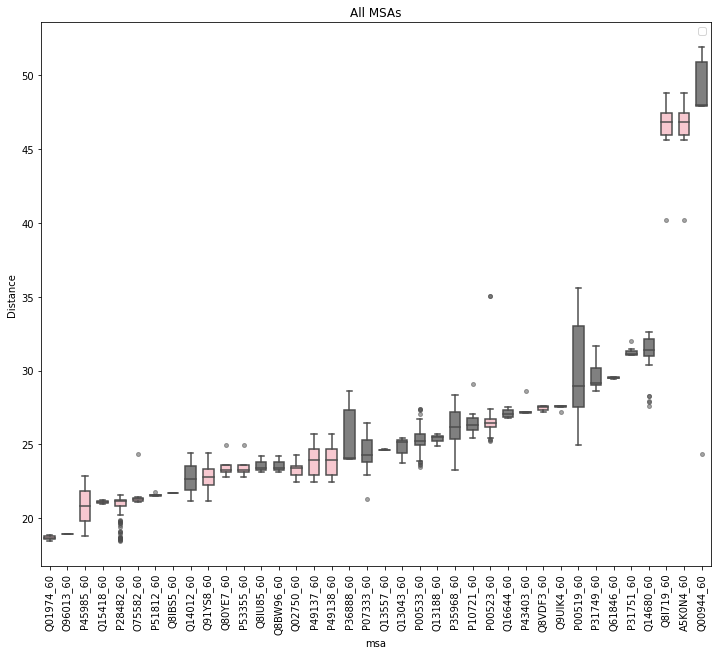

In [60]:
# Create a new figure
plt.figure(figsize=(12,10))

# Create a boxplot for all MSAs, sorted by median value
flierprops = dict(marker = 'o',  markersize= 4, alpha= .5)

# specify the color by group
group_colors = {x: 'pink' if x in g1_msa else 'grey' for x in medians.index.unique()}

sns.boxplot(data= df, y='median', x= 'msa', order=medians.index, width= 0.6, color= 'gray', flierprops= flierprops, palette= group_colors)

# Add title and axis labels
plt.legend()
plt.title("All MSAs")
plt.ylabel('Distance')
plt.xticks(rotation= 90)

# Show the plot
plt.show()

## Another approach - grouping by CRE occuring in a PFAM domain, if not "others"

### groups with domain annotation.  
As many groups as CREs covering at least 25% of a PFAM domain

In [10]:
#msa_regions_pdbs = pd.read_csv('../datasets/msa_regions_pdbs.tsv', sep= '\t')
all_msas = pd.read_csv('../datasets/all_msas.tsv', sep= '\t')
all_msas = all_msas[all_msas.msa.str.endswith("60")]
all_msas.drop(columns= 'length_msa', inplace= True)

pfam_cre_overlap = pd.read_csv('../datasets/pfam_cre_overlap.tsv', sep= '\t')
pfam_domains = pd.read_csv('../datasets/pfam_domains.tsv', sep= '\t')
pfam_domains

,uniprot,pfam,protein_name,start,end,domain_name
0,A5K0N4,PF00027,cGMP-dependent protein kinase,71,151,cNMP_binding
1,A5K0N4,PF00069,cGMP-dependent protein kinase,535,791,Pkinase
2,Q8I719,PF00027,cGMP-dependent protein kinase,78,158,cNMP_binding
3,Q8I719,PF00069,cGMP-dependent protein kinase,542,798,Pkinase
4,O74536,PF16579,SNF1-like protein kinase ssp2,451,573,AdenylateSensor
...,...,...,...,...,...,...
104,Q8IBS5,PF00069,Calcium-dependent protein kinase 4,70,328,Pkinase
105,Q8IBS5,PF13499,Calcium-dependent protein kinase 4,381,450,NaN
106,Q8VDF3,PF00069,Death-associated protein kinase 2,23,285,Pkinase
107,Q9UIK4,PF00069,Death-associated protein kinase 2,23,285,Pkinase


In [11]:
# Drop the Protein Kinase domain. They're already annotated (KD)
pfam_group = pfam_cre_overlap[~((pfam_cre_overlap.pfam == 'PF07714') | (pfam_cre_overlap.pfam == 'PF00069'))]
pfam_group

,uniprot,pfam,protein_name,start,end,domain_name,term_id_cre,start_cre,end_cre,length_cre,term_id_kd,start_kd,end_kd,overlap,fraction_overlap
0,O74536,PF08587,SNF1-like protein kinase ssp2,305,345,UBA_2,cre21,305,351,47,kd21,34,285,41,0.87
1,O96013,PF00786,Serine/threonine-protein kinase PAK 4,10,63,PBD,cre32,1,130,130,kd34,321,572,55,0.42
2,P00519,PF00018,Tyrosine-protein kinase ABL1,67,113,SH3_1,cre36,61,233,173,kd37,242,493,48,0.28
3,P00519,PF00017,Tyrosine-protein kinase ABL1,127,202,SH2,cre36,61,233,173,kd37,242,493,77,0.45
4,P00523,PF00018,Proto-oncogene tyrosine-protein kinase Src,87,134,SH3_1,cre37,88,248,161,kd38,267,520,47,0.29
5,P00523,PF00017,Proto-oncogene tyrosine-protein kinase Src,148,230,SH2,cre37,88,248,161,kd38,267,520,84,0.52
9,P29323,PF14575,Ephrin type-B receptor 2,544,617,EphA2_TM,cre71,588,621,34,kd71,621,884,30,0.88
10,P31749,PF00169,RAC-alpha serine/threonine-protein kinase,7,106,PH,cre72,17,149,133,kd72,150,408,90,0.68
11,P31751,PF00169,RAC-beta serine/threonine-protein kinase,6,106,PH,cre73,17,151,135,kd73,152,409,90,0.67
16,Q00944,PF00373,Focal adhesion kinase 1,135,250,FERM_M,cre110,35,362,328,kd110,422,680,117,0.36


In [26]:
#to_merge = msa_regions_pdbs[['msa', 'uniprot', 'term_id_cre', 'start_cre', 'end_cre', 'term_id_kd', 'start_kd', 'end_kd']].drop_duplicates()

In [12]:
pfam_group = pfam_group.merge(all_msas)
pfam_group

,uniprot,pfam,protein_name,start,end,domain_name,term_id_cre,start_cre,end_cre,length_cre,term_id_kd,start_kd,end_kd,overlap,fraction_overlap,msa
0,O74536,PF08587,SNF1-like protein kinase ssp2,305,345,UBA_2,cre21,305,351,47,kd21,34,285,41,0.87,O74536_60
1,O96013,PF00786,Serine/threonine-protein kinase PAK 4,10,63,PBD,cre32,1,130,130,kd34,321,572,55,0.42,O96013_60
2,P00519,PF00018,Tyrosine-protein kinase ABL1,67,113,SH3_1,cre36,61,233,173,kd37,242,493,48,0.28,P00519_60
3,P00519,PF00017,Tyrosine-protein kinase ABL1,127,202,SH2,cre36,61,233,173,kd37,242,493,77,0.45,P00519_60
4,P00523,PF00018,Proto-oncogene tyrosine-protein kinase Src,87,134,SH3_1,cre37,88,248,161,kd38,267,520,47,0.29,P00523_60
5,P00523,PF00017,Proto-oncogene tyrosine-protein kinase Src,148,230,SH2,cre37,88,248,161,kd38,267,520,84,0.52,P00523_60
6,P29323,PF14575,Ephrin type-B receptor 2,544,617,EphA2_TM,cre71,588,621,34,kd71,621,884,30,0.88,P29323_60
7,P31749,PF00169,RAC-alpha serine/threonine-protein kinase,7,106,PH,cre72,17,149,133,kd72,150,408,90,0.68,P31749_60
8,P31751,PF00169,RAC-beta serine/threonine-protein kinase,6,106,PH,cre73,17,151,135,kd73,152,409,90,0.67,P31751_60
9,Q00944,PF00373,Focal adhesion kinase 1,135,250,FERM_M,cre110,35,362,328,kd110,422,680,117,0.36,Q00944_60


In [13]:
pfam_group.msa.nunique()

12

In [14]:
pfam_group.pfam.nunique()

9

In [15]:
pfam_group.uniprot.nunique()

11

In [8]:
pfam_group.term_id_cre.nunique()


11

### group with no domain anotation

In [16]:
regions = pd.read_csv('../datasets/regions.txt', sep= "\t")
kds = regions[regions.term_id.str.startswith("kd")].rename(columns= {'start': 'start_kd', 'end': 'end_kd'}).rename(columns= {'uniprot_acc': 'uniprot'})
cres = regions[regions.term_id.str.startswith("cre")].rename(columns= {'start': 'start_cre', 'end': 'end_cre'}).rename(columns= {'uniprot_acc': 'uniprot'})

In [17]:
regions_h = kds.merge(cres, left_on= 'uniprot', right_on= 'uniprot').rename(columns= {'term_id_x': 'kd_id', 'term_id_y': 'cre_id'})
regions_h

,uniprot,start_kd,end_kd,kd_id,start_cre,end_cre,cre_id
0,A0A2I0BVG8,56,325,kd1,346,353,cre1
1,A0A509AFG4,110,365,kd2,385,393,cre2
2,A0A509AHB6,57,324,kd3,345,352,cre3
3,A0A509AKL0,545,802,kd4,1,33,cre4
4,A0A509AQE6,118,372,kd5,394,402,cre5
...,...,...,...,...,...,...,...
288,Q9ZSA4,28,290,kd282,295,325,cre282
289,Q9ZUZ2,143,405,kd283,409,439,cre283
290,Q9ZV15,134,392,kd284,398,428,cre284
291,W0LYS5,31,287,kd285,287,327,cre285


In [18]:
# MSAs with no pfam annotation
others_group = all_msas[~all_msas.msa.isin(pfam_group.msa)]
others_group.msa.nunique()

238

In [19]:
others_group

,msa,uniprot
0,A0A2I0BVG8_60,A0A2I0BVG8
1,A0A2I0BVG8_60,A0A0D9QJY8
2,A0A2I0BVG8_60,A0A0L7M8D5
3,A0A2I0BVG8_60,A0A1Y3DU95
4,A0A2I0BVG8_60,A5KBU9
...,...,...
42077,W7JX98_60,W7JX98
42078,W7JX98_60,A0A0D9QPF1
42079,W7JX98_60,A0A0L7M3I6
42080,W7JX98_60,Q7PDS2


In [20]:
others_group = others_group.merge(regions_h) # , how= 'left'. TO check: add the transfered cres?
others_group

,msa,uniprot,start_kd,end_kd,kd_id,start_cre,end_cre,cre_id
0,A0A2I0BVG8_60,A0A2I0BVG8,56,325,kd1,346,353,cre1
1,A0A509AFG4_60,A0A509AFG4,110,365,kd2,385,393,cre2
2,A0A509AHB6_60,A0A509AHB6,57,324,kd3,345,352,cre3
3,A0A509AKL0_60,A0A509AKL0,545,802,kd4,1,33,cre4
4,A0A509AQE6_60,A0A509AQE6,118,372,kd5,394,402,cre5
...,...,...,...,...,...,...,...,...
328,Q9ZSA2_60,Q9ZSA2,80,338,kd280,343,373,cre280
329,Q9ZSA3_60,Q9ZSA3,36,305,kd281,309,339,cre281
330,Q9ZUZ2_60,Q9ZUZ2,143,405,kd283,409,439,cre283
331,Q9ZV15_60,Q9ZV15,134,392,kd284,398,428,cre284


#### Length distribution

In [21]:
others_group["cre_length"] = others_group.end_cre - others_group.start_cre + 1

In [22]:
others_group[['cre_id', 'cre_length']].drop_duplicates().cre_length.describe()#.plot(kind= 'hist')

count    245.000000
mean      58.848980
std       81.697598
min        6.000000
25%       26.000000
50%       31.000000
75%       68.000000
max      648.000000
Name: cre_length, dtype: float64

In [24]:
others_group

,msa,uniprot,start_kd,end_kd,kd_id,start_cre,end_cre,cre_id,cre_length
0,A0A2I0BVG8_60,A0A2I0BVG8,56,325,kd1,346,353,cre1,8
1,A0A509AFG4_60,A0A509AFG4,110,365,kd2,385,393,cre2,9
2,A0A509AHB6_60,A0A509AHB6,57,324,kd3,345,352,cre3,8
3,A0A509AKL0_60,A0A509AKL0,545,802,kd4,1,33,cre4,33
4,A0A509AQE6_60,A0A509AQE6,118,372,kd5,394,402,cre5,9
...,...,...,...,...,...,...,...,...,...
328,Q9ZSA2_60,Q9ZSA2,80,338,kd280,343,373,cre280,31
329,Q9ZSA3_60,Q9ZSA3,36,305,kd281,309,339,cre281,31
330,Q9ZUZ2_60,Q9ZUZ2,143,405,kd283,409,439,cre283,31
331,Q9ZV15_60,Q9ZV15,134,392,kd284,398,428,cre284,31


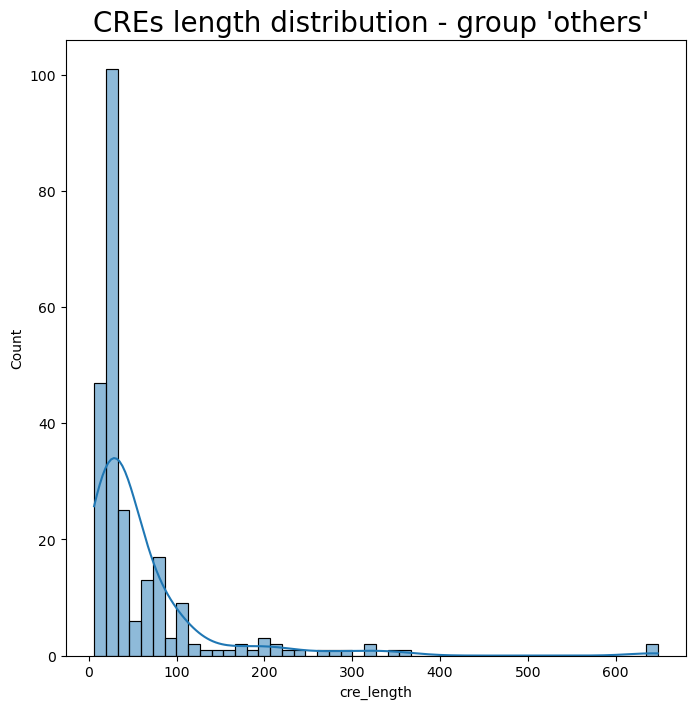

In [25]:
plt.figure(figsize=(8,8))
sns.histplot(others_group[['cre_id', 'cre_length']].drop_duplicates().cre_length, kde= True)
plt.title("CREs length distribution - group 'others' ", fontsize= 20)
plt.show()

#### Architecture

In [18]:
others_group

,msa,uniprot,start_kd,end_kd,kd_id,start_cre,end_cre,cre_id,cre_length
0,A0A2I0BVG8_60,A0A2I0BVG8,56,325,kd1,346,353,cre1,8
1,A0A509AFG4_60,A0A509AFG4,110,365,kd2,385,393,cre2,9
2,A0A509AHB6_60,A0A509AHB6,57,324,kd3,345,352,cre3,8
3,A0A509AKL0_60,A0A509AKL0,545,802,kd4,1,33,cre4,33
4,A0A509AQE6_60,A0A509AQE6,118,372,kd5,394,402,cre5,9
...,...,...,...,...,...,...,...,...,...
328,Q9ZSA2_60,Q9ZSA2,80,338,kd280,343,373,cre280,31
329,Q9ZSA3_60,Q9ZSA3,36,305,kd281,309,339,cre281,31
330,Q9ZUZ2_60,Q9ZUZ2,143,405,kd283,409,439,cre283,31
331,Q9ZV15_60,Q9ZV15,134,392,kd284,398,428,cre284,31


In [26]:
# Compare KD and CRE ranges to determine KD location in the sequences respect to CRE
# closed parameter 'neither' so not considering overlaps at the ends
def annotate_architecture(df):
    '''
    Returns a list indexed as df, with the corresponding 
    '''
    kd_intervals = []
    cre_intervals = []
    for start, end in zip(df.start_kd, df.end_kd):
        kd_intervals.append(pd.Interval(start, end, closed= 'neither'))

    for start, end in zip(df.start_cre, df.end_cre):
        cre_intervals.append(pd.Interval(start, end, closed= 'neither'))

    # List with possible architectures: n-ter, c-ter, within-kd
    kd_location = []
    cre_location = []
    for kd_inter, cre_inter in zip(kd_intervals, cre_intervals):

        if cre_inter.overlaps(kd_inter):

            if kd_inter.left <= cre_inter.left and kd_inter.right >= cre_inter.right:       # Check if CRE is completely within KD
                kd_location.append("within-kd")
                cre_location.append("within-kd")

            else:
                overlap_percentage = round(((min(kd_inter.right, cre_inter.right) - max(kd_inter.left, cre_inter.left)) +1) / ((cre_inter.right - cre_inter.left) +1)* 100)
                kd_location.append(f"overlaps-kd {overlap_percentage}%")
                cre_location.append(f"overlaps-kd {overlap_percentage}%")

        elif kd_inter > cre_inter:
            kd_location.append("c-ter")
            cre_location.append("n-ter")

        elif kd_inter < cre_inter:
            kd_location.append("n-ter")
            cre_location.append("c-ter")
    ###
        else:
            print('error')
    
    return [kd_location, cre_location]

In [27]:
others_group["kd_location"] = annotate_architecture(others_group)[0]
others_group["cre_location"] = annotate_architecture(others_group)[1]
others_group

,msa,uniprot,start_kd,end_kd,kd_id,start_cre,end_cre,cre_id,cre_length,kd_location,cre_location
0,A0A2I0BVG8_60,A0A2I0BVG8,56,325,kd1,346,353,cre1,8,n-ter,c-ter
1,A0A509AFG4_60,A0A509AFG4,110,365,kd2,385,393,cre2,9,n-ter,c-ter
2,A0A509AHB6_60,A0A509AHB6,57,324,kd3,345,352,cre3,8,n-ter,c-ter
3,A0A509AKL0_60,A0A509AKL0,545,802,kd4,1,33,cre4,33,c-ter,n-ter
4,A0A509AQE6_60,A0A509AQE6,118,372,kd5,394,402,cre5,9,n-ter,c-ter
...,...,...,...,...,...,...,...,...,...,...,...
328,Q9ZSA2_60,Q9ZSA2,80,338,kd280,343,373,cre280,31,n-ter,c-ter
329,Q9ZSA3_60,Q9ZSA3,36,305,kd281,309,339,cre281,31,n-ter,c-ter
330,Q9ZUZ2_60,Q9ZUZ2,143,405,kd283,409,439,cre283,31,n-ter,c-ter
331,Q9ZV15_60,Q9ZV15,134,392,kd284,398,428,cre284,31,n-ter,c-ter


In [28]:
others_group.kd_location.value_counts()

n-ter              249
c-ter               73
within-kd            8
overlaps-kd 6%       2
overlaps-kd 44%      1
Name: kd_location, dtype: int64

In [22]:
others_group.cre_location.value_counts()

c-ter              249
n-ter               73
within-kd            8
overlaps-kd 6%       2
overlaps-kd 44%      1
Name: cre_location, dtype: int64

#### Secondary structure content

In [29]:
mobidb_secondary_scores = pd.read_csv('../datasets/mobidb_secondary_scores.tsv', sep= '\t') # , dtype= {'score_helix_fess': list, 'score_sheet_fess': list, 'score_coil_fess': list}
mobidb_secondary_scores.rename(columns= {'uniprot_acc': 'uniprot'}, inplace= True)
mobidb_secondary_scores

,uniprot,length,score_helix_fess,score_sheet_fess,score_coil_fess
0,A0A091DQI4,973,"[0.004, 0.068, 0.114, 0.153, 0.145, 0.125, 0.1...","[0.006, 0.454, 0.59, 0.617, 0.618, 0.535, 0.37...","[0.99, 0.478, 0.296, 0.229, 0.237, 0.341, 0.51..."
1,A0A0A2V081,315,"[0.003, 0.028, 0.03, 0.011, 0.013, 0.054, 0.12...","[0.002, 0.044, 0.051, 0.037, 0.016, 0.015, 0.0...","[0.995, 0.927, 0.919, 0.952, 0.97, 0.931, 0.85..."
2,A0A0D9R447,433,"[0.003, 0.021, 0.02, 0.018, 0.054, 0.082, 0.12...","[0.002, 0.064, 0.068, 0.107, 0.141, 0.213, 0.2...","[0.995, 0.915, 0.912, 0.874, 0.805, 0.706, 0.5..."
3,A0A0D9RZF3,974,"[0.003, 0.018, 0.019, 0.023, 0.027, 0.03, 0.03...","[0.01, 0.516, 0.633, 0.636, 0.653, 0.61, 0.437...","[0.987, 0.467, 0.348, 0.341, 0.32, 0.359, 0.52..."
4,A0A0E0IYS8,513,"[0.003, 0.011, 0.013, 0.01, 0.038, 0.036, 0.03...","[0.002, 0.055, 0.064, 0.028, 0.027, 0.031, 0.0...","[0.995, 0.933, 0.923, 0.962, 0.935, 0.933, 0.9..."
...,...,...,...,...,...
8406,D6W6N7,359,"[0.003, 0.039, 0.119, 0.146, 0.157, 0.236, 0.2...","[0.002, 0.071, 0.197, 0.187, 0.134, 0.142, 0.1...","[0.995, 0.89, 0.684, 0.666, 0.709, 0.622, 0.58..."
8407,G5EA63,395,"[0.003, 0.015, 0.058, 0.035, 0.052, 0.05, 0.06...","[0.002, 0.034, 0.028, 0.023, 0.034, 0.064, 0.0...","[0.995, 0.951, 0.914, 0.942, 0.914, 0.887, 0.8..."
8408,H0Z3Y5,1130,"[0.003, 0.028, 0.041, 0.063, 0.08, 0.126, 0.11...","[0.003, 0.363, 0.592, 0.684, 0.671, 0.577, 0.4...","[0.994, 0.609, 0.367, 0.253, 0.249, 0.297, 0.4..."
8409,P36507,400,"[0.004, 0.167, 0.198, 0.199, 0.121, 0.046, 0.0...","[0.002, 0.088, 0.092, 0.107, 0.118, 0.08, 0.09...","[0.994, 0.746, 0.711, 0.694, 0.76, 0.873, 0.86..."


In [30]:
# Set scores columns as list type
mobidb_secondary_scores.score_helix_fess = mobidb_secondary_scores.score_helix_fess.apply(lambda x: eval(x))
mobidb_secondary_scores.score_sheet_fess = mobidb_secondary_scores.score_sheet_fess.apply(lambda x: eval(x))
mobidb_secondary_scores.score_coil_fess = mobidb_secondary_scores.score_coil_fess.apply(lambda x: eval(x))

In [31]:
mobidb_secondary_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8411 entries, 0 to 8410
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   uniprot           8411 non-null   object
 1   length            8411 non-null   int64 
 2   score_helix_fess  8411 non-null   object
 3   score_sheet_fess  8411 non-null   object
 4   score_coil_fess   8411 non-null   object
dtypes: int64(1), object(4)
memory usage: 328.7+ KB


In [32]:
scores_df = others_group.merge(mobidb_secondary_scores) 
scores_df

,msa,uniprot,start_kd,end_kd,kd_id,start_cre,end_cre,cre_id,cre_length,kd_location,cre_location,length,score_helix_fess,score_sheet_fess,score_coil_fess
0,A0A2I0BVG8_60,A0A2I0BVG8,56,325,kd1,346,353,cre1,8,n-ter,c-ter,524,"[0.003, 0.027, 0.055, 0.079, 0.165, 0.187, 0.2...","[0.002, 0.096, 0.165, 0.182, 0.168, 0.139, 0.1...","[0.995, 0.877, 0.78, 0.739, 0.667, 0.674, 0.66..."
1,A0A509AFG4_60,A0A509AFG4,110,365,kd2,385,393,cre2,9,n-ter,c-ter,554,"[0.003, 0.122, 0.2, 0.225, 0.231, 0.256, 0.248...","[0.002, 0.102, 0.342, 0.431, 0.487, 0.497, 0.4...","[0.995, 0.776, 0.459, 0.344, 0.282, 0.247, 0.3..."
2,A0A509AHB6_60,A0A509AHB6,57,324,kd3,345,352,cre3,8,n-ter,c-ter,523,"[0.003, 0.03, 0.077, 0.103, 0.187, 0.17, 0.183...","[0.002, 0.086, 0.153, 0.151, 0.166, 0.168, 0.1...","[0.995, 0.884, 0.77, 0.746, 0.647, 0.661, 0.64..."
3,A0A509AKL0_60,A0A509AKL0,545,802,kd4,1,33,cre4,33,c-ter,n-ter,856,"[0.003, 0.027, 0.242, 0.279, 0.25, 0.145, 0.04...","[0.002, 0.035, 0.025, 0.043, 0.179, 0.291, 0.2...","[0.995, 0.938, 0.733, 0.678, 0.572, 0.564, 0.6..."
4,A0A509AQE6_60,A0A509AQE6,118,372,kd5,394,402,cre5,9,n-ter,c-ter,562,"[0.003, 0.074, 0.148, 0.215, 0.224, 0.209, 0.1...","[0.002, 0.181, 0.235, 0.237, 0.234, 0.188, 0.1...","[0.994, 0.745, 0.617, 0.549, 0.542, 0.603, 0.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,Q9ZSA2_60,Q9ZSA2,80,338,kd280,343,373,cre280,31,n-ter,c-ter,531,"[0.003, 0.037, 0.056, 0.091, 0.12, 0.192, 0.21...","[0.002, 0.176, 0.302, 0.335, 0.289, 0.219, 0.2...","[0.994, 0.787, 0.642, 0.574, 0.591, 0.589, 0.5..."
329,Q9ZSA3_60,Q9ZSA3,36,305,kd281,309,339,cre281,31,n-ter,c-ter,498,"[0.003, 0.036, 0.06, 0.079, 0.059, 0.03, 0.034...","[0.002, 0.097, 0.158, 0.226, 0.197, 0.113, 0.1...","[0.995, 0.868, 0.783, 0.696, 0.744, 0.857, 0.8..."
330,Q9ZUZ2_60,Q9ZUZ2,143,405,kd283,409,439,cre283,31,n-ter,c-ter,595,"[0.003, 0.041, 0.066, 0.085, 0.084, 0.066, 0.0...","[0.003, 0.167, 0.344, 0.437, 0.499, 0.5, 0.536...","[0.994, 0.792, 0.59, 0.478, 0.417, 0.434, 0.39..."
331,Q9ZV15_60,Q9ZV15,134,392,kd284,398,428,cre284,31,n-ter,c-ter,583,"[0.003, 0.024, 0.033, 0.037, 0.027, 0.027, 0.0...","[0.003, 0.089, 0.184, 0.371, 0.422, 0.381, 0.2...","[0.994, 0.887, 0.784, 0.592, 0.551, 0.592, 0.7..."


In [33]:
scores_df.msa.nunique()

238

In [34]:
prueba = scores_df[scores_df.msa == 'Q9ZSA2_60']
prueba

,msa,uniprot,start_kd,end_kd,kd_id,start_cre,end_cre,cre_id,cre_length,kd_location,cre_location,length,score_helix_fess,score_sheet_fess,score_coil_fess
328,Q9ZSA2_60,Q9ZSA2,80,338,kd280,343,373,cre280,31,n-ter,c-ter,531,"[0.003, 0.037, 0.056, 0.091, 0.12, 0.192, 0.21...","[0.002, 0.176, 0.302, 0.335, 0.289, 0.219, 0.2...","[0.994, 0.787, 0.642, 0.574, 0.591, 0.589, 0.5..."


In [35]:
helix = prueba[['msa', 'score_helix_fess']].explode('score_helix_fess')
helix["pos"] = [ i+1 for i in range(len(helix)) ]
helix["element"] = "H"
helix = helix.rename(columns= {'score_helix_fess': 'score'}).reset_index(drop= True)
# Add feature name based on coordinates
helix["feature"] = 'rest' # all that is not CRE nor KD
helix.loc[((helix.pos >= prueba.start_cre.values[0]) & (helix.pos <= prueba.end_cre.values[0])), "feature"] = 'CRE'
helix.loc[((helix.pos >= prueba.start_kd.values[0]) & (helix.pos <= prueba.end_kd.values[0])), "feature"] = 'KD'


sheet = prueba[['msa', 'score_sheet_fess']].explode('score_sheet_fess')
sheet["pos"] = [ i+1 for i in range(len(sheet)) ]
sheet["element"] = "S"
sheet = sheet.rename(columns= {'score_sheet_fess': 'score'}).reset_index(drop= True)
# Add feature name based on coordinates
sheet["feature"] = 'rest' # all that is not CRE nor KD
sheet.loc[((sheet.pos >= prueba.start_cre.values[0]) & (sheet.pos <= prueba.end_cre.values[0])), "feature"] = 'CRE'
sheet.loc[((sheet.pos >= prueba.start_kd.values[0]) & (sheet.pos <= prueba.end_kd.values[0])), "feature"] = 'KD'


coil = prueba[['msa', 'score_coil_fess']].explode('score_coil_fess')
coil["pos"] = [ i+1 for i in range(len(coil)) ]
coil["element"] = "C"
coil = coil.rename(columns= {'score_coil_fess': 'score'}).reset_index(drop= True)
# Add feature name based on coordinates
coil["feature"] = 'rest' # all that is not CRE nor KD
coil.loc[((coil.pos >= prueba.start_cre.values[0]) & (coil.pos <= prueba.end_cre.values[0])), "feature"] = 'CRE'
coil.loc[((coil.pos >= prueba.start_kd.values[0]) & (coil.pos <= prueba.end_kd.values[0])), "feature"] = 'KD'

df_scores = pd.concat([helix, sheet, coil])

In [36]:
df_scores

,msa,score,pos,element,feature
0,Q9ZSA2_60,0.003,1,H,rest
1,Q9ZSA2_60,0.037,2,H,rest
2,Q9ZSA2_60,0.056,3,H,rest
3,Q9ZSA2_60,0.091,4,H,rest
4,Q9ZSA2_60,0.12,5,H,rest
...,...,...,...,...,...
526,Q9ZSA2_60,0.658,527,C,rest
527,Q9ZSA2_60,0.729,528,C,rest
528,Q9ZSA2_60,0.788,529,C,rest
529,Q9ZSA2_60,0.852,530,C,rest


In [37]:
df_scores.feature.value_counts()

KD      777
rest    723
CRE      93
Name: feature, dtype: int64

In [32]:
msa = 'Q9ZSA2_60'
# For each MSA, store the means and medians
to_concat = pd.DataFrame()
for (element, feature), group in df_scores.groupby(["element", "feature"]):
    print(element, feature)
    entry = pd.DataFrame(data = {'msa': msa, 'feature': feature, 'element': element, 'median_score':  group.score.median(), 'mean_score': group.score.mean() }, index= [0] )
    to_concat = pd.concat([to_concat, entry])
    #summary = pd.concat([summary, entry])
to_concat

C CRE
C KD
C rest
H CRE
H KD
H rest
S CRE
S KD
S rest


,msa,feature,element,median_score,mean_score
0,Q9ZSA2_60,CRE,C,0.059,0.230710
0,Q9ZSA2_60,KD,C,0.283,0.346429
0,Q9ZSA2_60,rest,C,0.555,0.469174
0,Q9ZSA2_60,CRE,H,0.935,0.754645
0,Q9ZSA2_60,KD,H,0.464,0.508158
0,Q9ZSA2_60,rest,H,0.276,0.441577
0,Q9ZSA2_60,CRE,S,0.008,0.014452
0,Q9ZSA2_60,KD,S,0.088,0.145390
0,Q9ZSA2_60,rest,S,0.047,0.089187


<AxesSubplot:xlabel='feature', ylabel='median_score'>

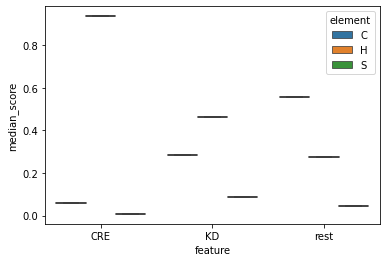

In [33]:
sns.boxplot(data= to_concat, y='median_score', x= 'feature', hue= 'element', order= ['CRE', 'KD', 'rest']) # ok!

In [76]:
df_scores

,msa,score,element
328,Q9ZSA2_60,0.003,H
328,Q9ZSA2_60,0.037,H
328,Q9ZSA2_60,0.056,H
328,Q9ZSA2_60,0.091,H
328,Q9ZSA2_60,0.12,H
...,...,...,...
328,Q9ZSA2_60,0.658,C
328,Q9ZSA2_60,0.729,C
328,Q9ZSA2_60,0.788,C
328,Q9ZSA2_60,0.852,C


In [38]:
# Secondary structure scor boxplots with statistics
# palette: https://coolors.co/palette/ef476f-ffd166-06d6a0-118ab2-073b4c
# annotator: https://levelup.gitconnected.com/statistics-on-seaborn-plots-with-statannotations-2bfce0394c00

summary = pd.DataFrame() # columns= ['msa', 'element', 'feature', 'median_score', 'mean_score']

for msa, df in scores_df.groupby('msa'):


    helix = df[['msa', 'score_helix_fess']].explode('score_helix_fess')
    helix["pos"] = [ i+1 for i in range(len(helix)) ]
    helix["element"] = "H"
    helix = helix.rename(columns= {'score_helix_fess': 'score'}).reset_index(drop= True)
    # Add feature name based on coordinates
    helix["feature"] = 'rest' # all that is not CRE nor KD
    helix.loc[((helix.pos >= df.start_cre.values[0]) & (helix.pos <= df.end_cre.values[0])), "feature"] = 'CRE'
    helix.loc[((helix.pos >= df.start_kd.values[0]) & (helix.pos <= df.end_kd.values[0])), "feature"] = 'KD'


    sheet = df[['msa', 'score_sheet_fess']].explode('score_sheet_fess')
    sheet["pos"] = [ i+1 for i in range(len(sheet)) ]
    sheet["element"] = "S"
    sheet = sheet.rename(columns= {'score_sheet_fess': 'score'}).reset_index(drop= True)
    # Add feature name based on coordinates
    sheet["feature"] = 'rest' # all that is not CRE nor KD
    sheet.loc[((sheet.pos >= df.start_cre.values[0]) & (sheet.pos <= df.end_cre.values[0])), "feature"] = 'CRE'
    sheet.loc[((sheet.pos >= df.start_kd.values[0]) & (sheet.pos <= df.end_kd.values[0])), "feature"] = 'KD'


    coil = df[['msa', 'score_coil_fess']].explode('score_coil_fess')
    coil["pos"] = [ i+1 for i in range(len(coil)) ]
    coil["element"] = "C"
    coil = coil.rename(columns= {'score_coil_fess': 'score'}).reset_index(drop= True)
    # Add feature name based on coordinates
    coil["feature"] = 'rest' # all that is not CRE nor KD
    coil.loc[((coil.pos >= df.start_cre.values[0]) & (coil.pos <= df.end_cre.values[0])), "feature"] = 'CRE'
    coil.loc[((coil.pos >= df.start_kd.values[0]) & (coil.pos <= df.end_kd.values[0])), "feature"] = 'KD'

    df_scores = pd.concat([helix, sheet, coil])

    # # For each MSA, store the means and medians
    # for feature, group in df_scores.groupby("feature"):
    #     entry = pd.DataFrame(data = {'msa': msa, 'feature': feature, 'median_score':  group.score.median(), 'mean_score': group.score.mean() }, index= [0] )
    #     summary = pd.concat([summary, entry])

    # For each MSA, store the means and medians
    to_concat = pd.DataFrame()
    for (element, feature), group in df_scores.groupby(["element", "feature"]):
        #print(element, feature)
        entry = pd.DataFrame(data = {'msa': msa, 'feature': feature, 'element': element, 'median_score':  group.score.median(), 'mean_score': group.score.mean() }, index= [0] )
        to_concat = pd.concat([to_concat, entry])
        summary = pd.concat([summary, to_concat])
    

    # # Plot
    # colors= ["#EF476F", "#06D6A0", "#118AB2"]
    # sns.set(rc={'figure.figsize':(10, 8)}, font_scale= 2)

    # flierprops = dict(marker='o', markerfacecolor='gray', markersize= 5,  markeredgecolor='black')
    # ax = sns.boxplot(data= df_scores, x= 'feature', y= 'score', hue= 'element', order= ['CRE', 'KD', 'rest'], width= 0.45, linewidth= 3, medianprops=dict(color="gray", alpha=0.9), palette= colors, flierprops= flierprops) # , showmeans= True, meanline= True , notch= True , showmeans= True, meanline= True

    # # # Combinations to compare
    # # comb = combinations(scores_df.feature.unique(), 2)
    # # pairs = [ i for i in comb ]

    # # annotator = Annotator(ax= ax, pairs= pairs, data= summary, x= 'feature', y= 'median_score')
    # # annotator.configure(test= 'Mann-Whitney', text_format='star')
    # # annotator.apply_and_annotate()

    # #plt.rcParams['font.size'] = 16
    # plt.title(f"Secondary structure content for msa {msa}")
    # plt.ylabel("Fess score")
    # plt.xlabel("")
    # plt.legend(loc= 1, bbox_to_anchor=(1.20, 1))
    # plt.tight_layout()
    # plt.savefig(f'../plots/secondary_structure/by_msa/{msa}.png', dpi= 200)
    # plt.show()

In [39]:
df_scores#.isna().any()

,msa,score,pos,element,feature
0,W7JX98_60,0.003,1,H,CRE
1,W7JX98_60,0.112,2,H,CRE
2,W7JX98_60,0.352,3,H,CRE
3,W7JX98_60,0.401,4,H,CRE
4,W7JX98_60,0.49,5,H,CRE
...,...,...,...,...,...
848,W7JX98_60,0.68,849,C,rest
849,W7JX98_60,0.646,850,C,rest
850,W7JX98_60,0.677,851,C,rest
851,W7JX98_60,0.765,852,C,rest


In [37]:
for (element, feature), group in df_scores.groupby(["element", "feature"]):
    print(element, feature)
    entry = pd.DataFrame(data = {'msa': msa, 'feature': feature, 'element': element, 'median_score':  group.score.median(), 'mean_score': group.score.mean() }, index= [0] )
    print(entry)
    # to_concat = pd.concat([to_concat, entry])
    # summary = pd.concat([summary, to_concat])

C CRE
         msa feature element  median_score  mean_score
0  W7JX98_60     CRE       C         0.551    0.573586
C KD
         msa feature element  median_score  mean_score
0  W7JX98_60      KD       C        0.3475    0.391384
C rest
         msa feature element  median_score  mean_score
0  W7JX98_60    rest       C        0.3595    0.393698
H CRE
         msa feature element  median_score  mean_score
0  W7JX98_60     CRE       H         0.289    0.279655
H KD
         msa feature element  median_score  mean_score
0  W7JX98_60      KD       H        0.2675    0.365694
H rest
         msa feature element  median_score  mean_score
0  W7JX98_60    rest       H        0.2335    0.297852
S CRE
         msa feature element  median_score  mean_score
0  W7JX98_60     CRE       S         0.074    0.146828
S KD
         msa feature element  median_score  mean_score
0  W7JX98_60      KD       S         0.182     0.24293
S rest
         msa feature element  median_score  mean_score
0  W7JX98_6

In [36]:
entry

,msa,feature,element,median_score,mean_score
0,W7JX98_60,rest,S,0.234,0.308461


In [40]:
summary.msa.nunique()

238

In [41]:
summary = summary.drop_duplicates()#[summary.element.isna()]

In [42]:
summary

,msa,feature,element,median_score,mean_score
0,A0A2I0BVG8_60,CRE,C,0.3625,0.372750
0,A0A2I0BVG8_60,KD,C,0.3020,0.347322
0,A0A2I0BVG8_60,rest,C,0.2750,0.328809
0,A0A2I0BVG8_60,CRE,H,0.6305,0.621125
0,A0A2I0BVG8_60,KD,H,0.4580,0.484422
...,...,...,...,...,...
0,W7JX98_60,KD,H,0.2675,0.365694
0,W7JX98_60,rest,H,0.2335,0.297852
0,W7JX98_60,CRE,S,0.0740,0.146828
0,W7JX98_60,KD,S,0.1820,0.242930


In [43]:
comb = combinations(summary.feature.unique(), 2)
for i in comb:
    print(i)

('CRE', 'KD')
('CRE', 'rest')
('KD', 'rest')


In [55]:
!pip install statsmodels

You should consider upgrading via the 'c:\users\user\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.



  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9


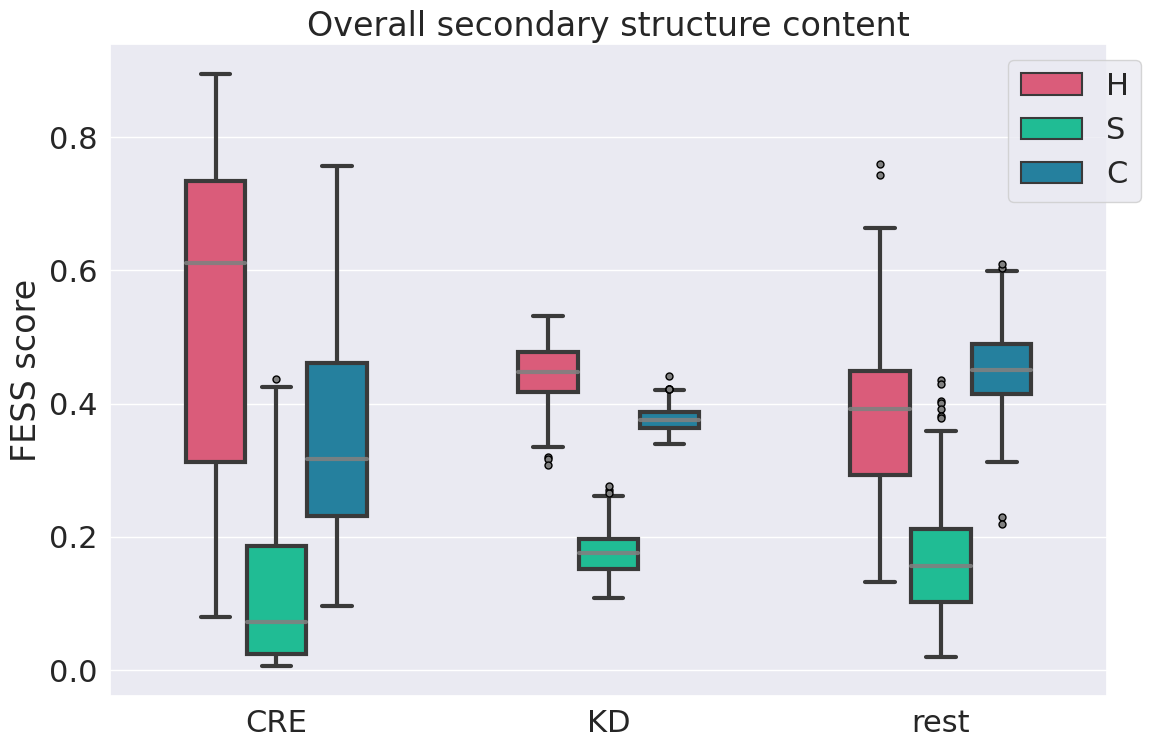

In [46]:
# Summary plot
colors= ["#EF476F", "#06D6A0", "#118AB2"]
sns.set(rc={'figure.figsize':(12, 8)}, font_scale= 2)

flierprops = dict(marker='o', markerfacecolor='gray', markersize= 5,  markeredgecolor='black')
ax = sns.boxplot(data= summary, x= 'feature', y= 'mean_score', hue= 'element', hue_order= ['H', 'S', 'C'], order= ['CRE', 'KD', 'rest'], width= 0.55, linewidth= 3, medianprops=dict(color="gray", alpha=0.9), palette= colors, flierprops= flierprops) # , notch= True , showmeans= True, meanline= True

# Combinations to compare
comb = combinations(summary.feature.unique(), 2)
pairs = [ i for i in comb ]

# annotator = Annotator(ax= ax, pairs= pairs, data= summary, x= 'feature', y= 'mean_score')
# annotator.configure(test= 'Mann-Whitney', text_format='star')
# annotator.apply_and_annotate()


#plt.rcParams['font.size'] = 16
plt.title(f"Overall secondary structure content")
plt.ylabel("FESS score")
plt.xlabel("")
plt.legend(loc= 1,  bbox_to_anchor=(1.05, 1)) # ,  bbox_to_anchor=(1.25, 1)
plt.tight_layout()
#plt.savefig(f'../plots/secondary_structure/overall_sec_content_mean.png', dpi=200)
plt.savefig(f'../plots/paper/overall_secondary_structure.png', dpi=300, transparent= True)
plt.show()

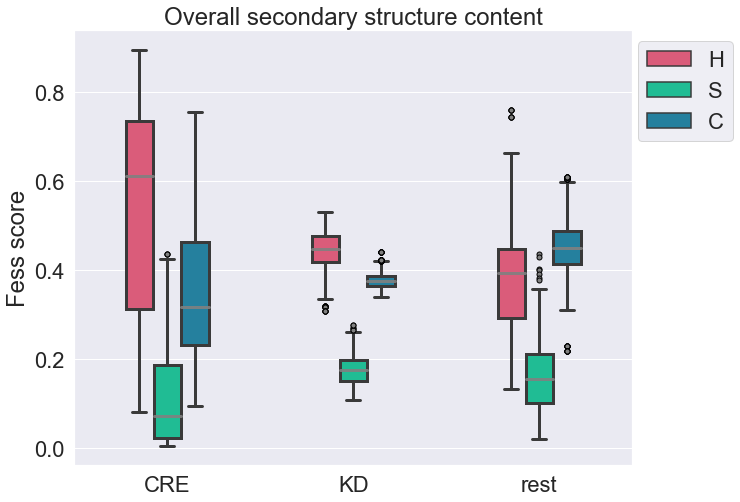

In [39]:
# Summary plot
colors= ["#EF476F", "#06D6A0", "#118AB2"]
sns.set(rc={'figure.figsize':(10, 8)}, font_scale= 2)

flierprops = dict(marker='o', markerfacecolor='gray', markersize= 5,  markeredgecolor='black')
ax = sns.boxplot(data= summary, x= 'feature', y= 'mean_score', hue= 'element', hue_order= ['H', 'S', 'C'], order= ['CRE', 'KD', 'rest'], width= 0.45, linewidth= 3, medianprops=dict(color="gray", alpha=0.9), palette= colors, flierprops= flierprops) # , notch= True , showmeans= True, meanline= True

# # Combinations to compare
# comb = combinations(scores_df.feature.unique(), 2)
# pairs = [ i for i in comb ]

# annotator = Annotator(ax= ax, pairs= pairs, data= summary, x= 'feature', y= 'median_score')
# annotator.configure(test= 'Mann-Whitney', text_format='star')
# annotator.apply_and_annotate()

#plt.rcParams['font.size'] = 16
plt.title(f"Overall secondary structure content")
plt.ylabel("Fess score")
plt.xlabel("")
plt.legend(loc= 1, bbox_to_anchor=(1.20, 1))
plt.show()